In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

## Load and clean the data

In [2]:
# Download the csv from link
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2021-02-13 10:01:12--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  2.72MB/s    in 0.2s    

2021-02-13 10:01:12 (2.72 MB/s) - ‘spam.csv’ saved [503663/503663]



In [9]:
# Read the csv and display the data
df_spam = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df_spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
# Clean the data by dropping unnecessary columns
df_spam = df_spam.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename the remaining columns to their actual names
df_spam.columns = ['labels', 'data']
df_spam.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Binarize the labels column
df_spam['b_labels'] = df_spam['labels'].map({'ham':0, 'spam':1})
Y = df_spam['b_labels'].values

## Split the data & Convert text to Sequences
#### Operations:
1. Train/Test split
2. Tokenize the sentences
3. Get Sequences from tokens
4. Apply sequence padding - ensures all embeddings are of same size

In [12]:
# Split the data in to train & test sets
df_train, df_test, y_train, y_test = train_test_split(df_spam['data'], Y, test_size=0.33)

In [13]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000

# Initialize a tokenizer and convert text data in to tokens
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

# Get train & test sequences using the tokenizer
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [16]:
# Get word to integer mapping from tokenizer object
word_idx = tokenizer.word_index

# Get the total of Unique tokens
V = len(word_idx)
print("Found %s unique tokens" %V)

Found 7217 unique tokens


In [17]:
# Pad the train data sequences to get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor: ', data_train.shape)

# Assign the sequence lenght to a variable for use in model building
T = data_train.shape[1]

Shape of data train tensor:  (3733, 162)


In [18]:
# Pad the test data sequences similar to train data
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of test data tensor: ', data_test.shape)

Shape of test data tensor:  (1839, 162)


## Model using Functional API

In [19]:
# Set the embedding layer dimensionality (custom)
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x) # Used instead of flatten since it globalmaxpool has same effect as flatten + pooling
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 162, 20)           144360    
_________________________________________________________________
conv1d (Conv1D)              (None, 160, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 53, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           24704 

In [20]:
# Compile the model with learning parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Fit the model to the data
print("Training model..")
r = model.fit(data_train, y_train, epochs=10, validation_data=(data_test, y_test))

Training model..
Epoch 1/10
117/117 [==============================] - 3s 18ms/step - loss: 0.4738 - accuracy: 0.8602 - val_loss: 0.2824 - val_accuracy: 0.8651
Epoch 2/10
117/117 [==============================] - 2s 16ms/step - loss: 0.2357 - accuracy: 0.8803 - val_loss: 0.1230 - val_accuracy: 0.9598
Epoch 3/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0507 - accuracy: 0.9855 - val_loss: 0.0657 - val_accuracy: 0.9842
Epoch 4/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0133 - accuracy: 0.9945 - val_loss: 0.0656 - val_accuracy: 0.9869
Epoch 5/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0038 - accuracy: 0.9997 - val_loss: 0.0682 - val_accuracy: 0.9880
Epoch 6/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0685 - val_accuracy: 0.9821
Epoch 7/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0753 - val

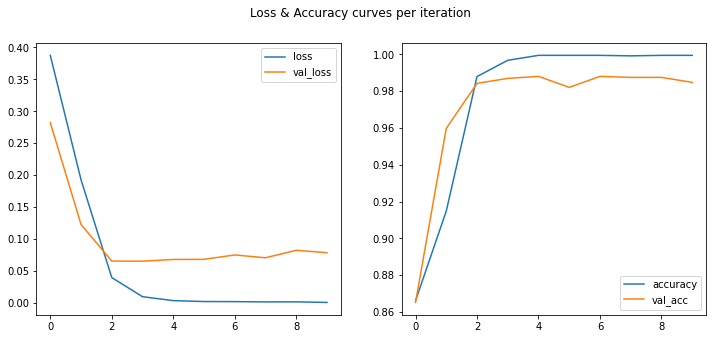

In [22]:
# Plot the loss & accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Loss & Accuracy curves per iteration")

# Loss per iteration plot
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()

# Accuracy per iteration plot
ax2.plot(r.history['accuracy'], label='accuracy')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.legend()

## Checking wrong model predictions

In [35]:
# Checking the wrong predictions
p_test = model.predict(data_test).argmax(axis=1)

In [36]:
# Label map
labels = '''ham 
spam'''.split("\n")
print(labels)

['ham ', 'spam']


In [42]:
misclassified = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified)
print('Sentence analyzed: ', df_test.iloc[i])
print('True label is: %s' % labels[y_test[i]])
print('Predicted label is: %s' % labels[p_test[i]])

Sentence analyzed:  Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP charge) See o2.co.uk/games 4 Terms + settings. No purchase
True label is: spam
Predicted label is: ham 


In [43]:
print(i)

90


In [48]:
from pprint import pprint
pprint('Sentence analyzed: %s' % df_test.iloc[i])
print('-----------------------------------------')
pprint('True label is: %s' % labels[y_test[i]])
pprint('Predicted label is: %s' % labels[p_test[i]])

('Sentence analyzed: Buy Space Invaders 4 a chance 2 win orig Arcade Game '
 'console. Press 0 for Games Arcade (std WAP charge) See o2.co.uk/games 4 '
 'Terms + settings. No purchase')
-----------------------------------------
'True label is: spam'
'Predicted label is: ham '


In [113]:
# Correctly classified example
correct_classify = np.where(p_test == y_test)[0]
i = np.random.choice(correct_classify)
pprint('Sentence analyzed: %s' % df_test.iloc[i])
print('-----------------------------------------')
pprint('True label is: %s' % labels[y_test[i]])
pprint('Predicted label is: %s' % labels[p_test[i]])

'Sentence analyzed: How dare you change my ring'
-----------------------------------------
'True label is: ham '
'Predicted label is: ham '
